## Building the CNN model for the Fasion-MNIST data

In [31]:
# Common imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

#For resetting the graph
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [32]:
from tensorflow.examples.tutorials.mnist import input_data
fashion_mnist = input_data.read_data_sets("/datasets/project/fashion-mnist")

Extracting /cxldata/datasets/project/fashion-mnist/train-images-idx3-ubyte.gz
Extracting /cxldata/datasets/project/fashion-mnist/train-labels-idx1-ubyte.gz
Extracting /cxldata/datasets/project/fashion-mnist/t10k-images-idx3-ubyte.gz
Extracting /cxldata/datasets/project/fashion-mnist/t10k-labels-idx1-ubyte.gz


In [33]:
X_train = fashion_mnist.train.images
X_test = fashion_mnist.test.images
y_train = fashion_mnist.train.labels.astype("int")
y_test = fashion_mnist.test.labels.astype("int")

In [34]:
X_train.shape,X_test.shape

((55000, 784), (10000, 784))

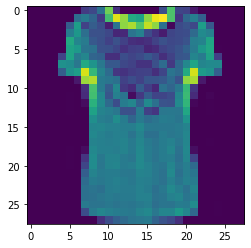

In [35]:
plt.imshow(X_train[1].reshape(28, -1))

In [36]:
y_train[1]

0

### Let us try first using the very simple approach without any optimizations

In [37]:
n_inputs = 28*28
n_hidden1 = 150
n_hidden2 = 150
n_outputs = 10

In [38]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [39]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [40]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [41]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [42]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [43]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()


In [44]:
n_epochs = 40
batch_size = 50

In [45]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(fashion_mnist.train.num_examples // batch_size):
            X_batch, y_batch = fashion_mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: fashion_mnist.validation.images,
                                            y: fashion_mnist.validation.labels})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "model_ckpts/my_model_final.ckpt")

0 Train accuracy: 0.72 Val accuracy: 0.8196
1 Train accuracy: 0.84 Val accuracy: 0.8348
2 Train accuracy: 0.9 Val accuracy: 0.8366
3 Train accuracy: 0.82 Val accuracy: 0.8522
4 Train accuracy: 0.8 Val accuracy: 0.852
5 Train accuracy: 0.9 Val accuracy: 0.8484
6 Train accuracy: 0.88 Val accuracy: 0.866
7 Train accuracy: 0.82 Val accuracy: 0.8664
8 Train accuracy: 0.82 Val accuracy: 0.866
9 Train accuracy: 0.92 Val accuracy: 0.8714
10 Train accuracy: 0.92 Val accuracy: 0.867
11 Train accuracy: 0.96 Val accuracy: 0.8738
12 Train accuracy: 0.86 Val accuracy: 0.8732
13 Train accuracy: 0.96 Val accuracy: 0.8758
14 Train accuracy: 0.88 Val accuracy: 0.8762
15 Train accuracy: 0.92 Val accuracy: 0.8754
16 Train accuracy: 0.92 Val accuracy: 0.881
17 Train accuracy: 0.96 Val accuracy: 0.877
18 Train accuracy: 0.96 Val accuracy: 0.8772
19 Train accuracy: 0.94 Val accuracy: 0.8828
20 Train accuracy: 0.96 Val accuracy: 0.882
21 Train accuracy: 0.92 Val accuracy: 0.8824
22 Train accuracy: 0.9 Val acc

As we can see we did not get a good accuracy that means we have to tweek somewhat into our code

### Let us use Batch Normalization

In [51]:
# By Batch Normalization
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")



training = tf.placeholder_with_default(False, shape=(), name='training')


hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")


bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

In [52]:
reset_graph()
from functools import partial

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [53]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [54]:
n_epochs = 100
batch_size = 200

In [55]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(fashion_mnist.train.num_examples // batch_size):
            X_batch, y_batch = fashion_mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: fashion_mnist.test.images,
                                                y: fashion_mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckpts/my_model_final.ckpt")

0 Test accuracy: 0.781
1 Test accuracy: 0.8049
2 Test accuracy: 0.8165
3 Test accuracy: 0.8269
4 Test accuracy: 0.8308
5 Test accuracy: 0.8363
6 Test accuracy: 0.8407
7 Test accuracy: 0.8453
8 Test accuracy: 0.8445
9 Test accuracy: 0.8483
10 Test accuracy: 0.8495
11 Test accuracy: 0.8535
12 Test accuracy: 0.8528
13 Test accuracy: 0.8558
14 Test accuracy: 0.855
15 Test accuracy: 0.8586
16 Test accuracy: 0.8591
17 Test accuracy: 0.8598
18 Test accuracy: 0.8625
19 Test accuracy: 0.8596
20 Test accuracy: 0.8641
21 Test accuracy: 0.8646
22 Test accuracy: 0.8665
23 Test accuracy: 0.8624
24 Test accuracy: 0.8615
25 Test accuracy: 0.8683
26 Test accuracy: 0.8659
27 Test accuracy: 0.8694
28 Test accuracy: 0.8697
29 Test accuracy: 0.8585
30 Test accuracy: 0.8687
31 Test accuracy: 0.869
32 Test accuracy: 0.8709
33 Test accuracy: 0.8668
34 Test accuracy: 0.8684
35 Test accuracy: 0.8707
36 Test accuracy: 0.873
37 Test accuracy: 0.8732
38 Test accuracy: 0.8714
39 Test accuracy: 0.8731
40 Test accura

Here also we are getting a bad accuracy that means further we have to do more optimization

### Now we are usinhg Gradient clipping what it does is that it is used to prevent Vanishing/Exploding Gradient problem more better as compared to the batch and normal of course.

In [59]:
# gradient clipping

reset_graph()

n_inputs = 28 * 28  
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [60]:
learning_rate = 0.01

threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [61]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckpts/my_model_final.ckpt")


0 Test accuracy: 0.3125
1 Test accuracy: 0.7945
2 Test accuracy: 0.8804
3 Test accuracy: 0.9025
4 Test accuracy: 0.911
5 Test accuracy: 0.9198
6 Test accuracy: 0.9257
7 Test accuracy: 0.9306
8 Test accuracy: 0.9343
9 Test accuracy: 0.9381
10 Test accuracy: 0.9409
11 Test accuracy: 0.9446
12 Test accuracy: 0.9493
13 Test accuracy: 0.9503
14 Test accuracy: 0.9499
15 Test accuracy: 0.9533
16 Test accuracy: 0.9545
17 Test accuracy: 0.9556
18 Test accuracy: 0.9589
19 Test accuracy: 0.9587


So as we can see that only in 20 epochs our accuracy is improved so much and it is above 95%.

#### We can further improve its accuracy by using several Fast Optimization so lets us use Adam Optimiser as it usually gives good accuracy

In [65]:
reset_graph()

n_inputs = 28 * 28 
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [66]:
learning_rate = 0.01

threshold = 1.0

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [67]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckpts/my_model_final.ckpt")


0 Test accuracy: 0.9591
1 Test accuracy: 0.9596
2 Test accuracy: 0.9673
3 Test accuracy: 0.9693
4 Test accuracy: 0.9701
5 Test accuracy: 0.9696
6 Test accuracy: 0.9722
7 Test accuracy: 0.9727
8 Test accuracy: 0.976
9 Test accuracy: 0.973
10 Test accuracy: 0.9742
11 Test accuracy: 0.9755
12 Test accuracy: 0.9761
13 Test accuracy: 0.9767
14 Test accuracy: 0.9717
15 Test accuracy: 0.9725
16 Test accuracy: 0.9753
17 Test accuracy: 0.9731
18 Test accuracy: 0.9786
19 Test accuracy: 0.9753


So, as we can see we have achieved a quite good accuracy with just tweeking our optimizer.